# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *Tarantino Ramona*

**Matricola**: *2082006*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras


In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model_save_path = '/content/drive/My Drive/NNDS modelli/gpt2_model'
gpt2_model.save(model_save_path)


### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

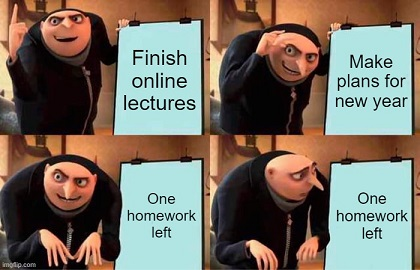

## Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a SHORT description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

The IMDB (Internet Movie Database) dataset is a collection of movie reviews used in the field of machine learning and natural language processing. It contains thousands of movie reviews left by users on IMDB, each review has a label that indicates whether the review expresses a positive or negative sentiment.
Usually this dataset is used for sentiment analysis, but in this case it was my training base for GPT2 to generate text on movie reviews.

The main characteristics of the dataset are:

- **Size:** contains 50,000 reviews, split evenly between positive and negative reviews. In my case due to RAM limitations I used the first 2000 samples to train the model.

- **Pre-processing:** Reviews are pre-processed to remove HTML markup and are already tokenized.

- **Applications:** It is considered a standard dataset for evaluating the performance of text classification algorithms and deep learning models.

- **Availability:** The IMDB dataset is freely available and can be easily downloaded and used through libraries such as TensorFlow.


In [ ]:
imdb_reviews_ds = tfds.load("imdb_reviews", split="train[:2000]", as_supervised=True)
BATCH_SIZE = 32


In [ ]:
train_ds = (
    imdb_reviews_ds.map(lambda review, _: review)  # extracts only the review text from the dataset, ignoring sentiment labels
    .batch(BATCH_SIZE)                             # for computational efficiency
    .cache()                                       # cache the dataset in memory after the data is loaded from disk
    .prefetch(tf.data.AUTOTUNE)                    # allows the dataset to prepare subsequent batches in advance while the model is working on training the current batch
                                                   # TensorFlow automatically adjusts the number of batches to prepare in advance
)

In [ ]:
for example, _ in imdb_reviews_ds.take(1):
    sample_review = example.numpy()

print(sample_review.decode('utf-8'))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.


### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

### Pre-trained model - GPT2

In [ ]:
!pip install keras_nlp
import keras_nlp

We configure a preprocessor and a GPT-2 model for causal language modeling where the goal is to predict the next token in the sequence given the previous tokens.

In [ ]:
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=128,
)
gpt2_model = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor,
)


In [ ]:
gpt2_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                     │                                              50,257 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gpt2_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ gpt2_backbone (GPT2Backbone)                  │ (None, None, 768)                      │     124,439,808 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_embedding (ReversibleEmbedding)         │ (None, None, 50257)                    │      38,597,376 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 124,439,808 (474.70 MB)

 Trainable params: 124,439,808 (474.70 MB)

 Non-trainable params: 0 (0.00 B)

From this summary we can see:
- The preprocessor is identified as including a GPT2Tokenizer type tokenizer. The tokenizer has a vocabulary of 50,257 tokens. This tokenizer is responsible for converting input text into sequences of tokens that can be processed by the model.

Input Layers:

- padding_mask: handles padding masks, inserted to ignore padding tokens when calculating predictions.
- token_ids: receives the token IDs generated by the tokenizer.

GPT2 Backbone:

- gpt2_backbone: the main layer of the model that performs language modeling. It has an output with size (None, None, 768), where 768 is the size of the embedding/token. The total number of parameters for this layer is 124,439,808 (huge number of parameters)

Output Layers:

- token_embedding: converts the backbone output into predictions for each token in the vocabulary, with output size (None, None, 50257), corresponding to the number of tokens in the vocabulary. This layer has 38,597,376 parameters, indicating a shared embedding matrix used for both input and output.

Total number of parameters trainable: 124.439.808, the memory size of these parameters is approximately 474.70 MB.


### LoRA

We have a model with a huge set of parameters and we want to optimize only a subset, this is done applying a factorization on the parameters of the model.
The goal is to identify a subset of parameters that is more efficient, with significantly fewer parameters than the original model.

The approach I used is the **LoRA** adaptation which is based on the empirical observation that LLMs possess intrinsic **low rank weights**. Studies have shown that many of the weights in **GPT-2** can be effectively approximated using low-rank decompositions. This means that even if the model has millions of parameters, the essential information that determines the model's behavior can be captured by a much smaller number of parameters.

Changing only a small portion of the model weights makes the adaptation much more computationally efficient than recalibrating all the model weights. This is particularly advantageous when working with GPT-2, where training or fine-tuning can be prohibitively expensive in terms of time and computational resources.

The main idea is to discover a sparse matrix that serves as a guide to transform the Δ0 matrix representing the model before fine tuning, we decompose this matrix using two matrices (A and B).



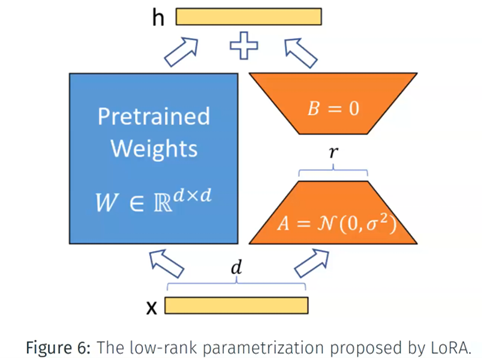

In [ ]:
from IPython.display import Image, display

display(Image('/content/Immagine1.png'))


In [ ]:
class LoraLayer(keras.layers.Layer):
    def __init__(self, base_dense_layer, rank, alpha, **kwargs):
        super(LoraLayer, self).__init__(**kwargs)
        self.base_dense_layer = base_dense_layer  # original dense layer to be adapted
        self.rank = rank                          # rank for the low-rank matrices
        self.alpha = alpha                        # scaling factor

        # original weight and bias of the dense layer
        self.original_weight = self.base_dense_layer.weights[0]
        self.original_bias = self.base_dense_layer.weights[1] if len(self.base_dense_layer.weights) > 1 else None

    def build(self, input_shape):
        self.lora_A = self.add_weight(
            shape=(self.original_weight.shape[0], self.rank),
            initializer="random_normal",
            trainable=True,
            name="lora_A"
        )
        self.lora_B = self.add_weight(
            shape=(self.rank, self.original_weight.shape[1]),
            initializer="random_normal",
            trainable=True,
            name="lora_B"
        )

        super(LoraLayer, self).build(input_shape)

    def call(self, inputs):
        lora_delta = tf.matmul(tf.matmul(inputs, self.lora_A), self.lora_B) * self.alpha

        original_output = self.base_dense_layer(inputs)

        # scale lora_delta to be compatible with original_output
        lora_delta = tf.expand_dims(lora_delta, axis=-1)  # expands the penultimate dimension
        lora_delta = tf.tile(lora_delta, [1, 1, 1, tf.shape(original_output)[-1]])  # replicate lora_delta to match the latest size of original_output

        # combine the original output with the LoRA adaptation
        output = original_output + lora_delta

        return output



Inside the build method, we create two low-rank matrices, lora_A and lora_B:

- lora_A = the number of rows of lora_A corresponds to the number of rows of the layer's original weight, while the number of columns is defined by self.rank. The "random_normal" initializer indicates that the initial weight values are sampled from a normal distribution.

- lora_B = create a weight matrix lora_B with shape (self.rank, self.original_weight.shape[1]). The number of rows of lora_B corresponds to the rank of the LoRA fit, while the number of columns corresponds to the number of columns of the layer's original weight. lora_B is also initialized with values sampled from a normal distribution.

lora_delta is obtained by multiplying the inputs by lora_A, the result by lora_B, and finally scaling the result with a factor self.alpha. This alpha factor is a hyperparameter that controls the amount of LoRA adaptation on the layer output.

Replace the original projection matrices with the new custom LoRA layer.

In [ ]:
gpt2_model.backbone.num_layers

12

In [ ]:
gpt2_model.backbone.layers

In [ ]:
for layer_idx in range(gpt2_model.backbone.num_layers):
  print(layer_idx)

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
gpt2_model.backbone.get_layer(f"transformer_layer_{0}")

In [ ]:
RANK = 8
ALPHA = 0.1
for layer_idx in range(gpt2_model.backbone.num_layers):
    # gets the single transformer layer (decoder_layer) at the specified index
    decoder_layer = gpt2_model.backbone.get_layer(f"transformer_layer_{layer_idx}")
    self_attention_layer = decoder_layer._self_attention_layer

    # apply LoRA adaptation to the dense layer of queries within the self-attention layer
    self_attention_layer._query_dense = LoraLayer(
        self_attention_layer._query_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

    # repeat the process for the dense layer of values within the self-attention layer
    self_attention_layer._value_dense = LoraLayer(
        self_attention_layer._value_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )


Freeze the layers of the model, only the LoRA layers will be trainable.

In [ ]:
for layer in gpt2_model._flatten_layers():
    lst_of_sublayers = list(layer._flatten_layers()) # for each layer we get a list of its sub-layers

    if len(lst_of_sublayers) == 1:  # we determine whether the current layer is a "leaf" of the model, a layer that has no further sub-layers
        if layer.name in ["lora_A", "lora_B"]:
            layer.trainable = True
        else:
            layer.trainable = False

In [ ]:
gpt2_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                     │                                              50,257 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gpt2_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ gpt2_backbone (GPT2Backbone)                  │ (None, None, 768)                      │     124,439,808 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_embedding (ReversibleEmbedding)         │ (None, None, 50257)                    │      38,597,376 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 138,614,016 (528.77 MB)

 Trainable params: 14,174,208 (54.07 MB)

 Non-trainable params: 124,439,808 (474.70 MB)

There are 14,174,208 trainable parameters in the new model, compared to 124,439,808 trainable parameters in the previous model. This means that all layers of GPT2 have been correctly set as untrainable, thus reducing the number of parameters that will be updated during training.

In [ ]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

In [ ]:
gpt2_model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)


In [ ]:
num_epochs = 15
hystory_with_lora = gpt2_model.fit(train_ds, epochs=num_epochs)

Epoch 1/15
63/63 [==============================] - 166s 1s/step - loss: 3.6996 - accuracy: 0.3022
Epoch 2/15
63/63 [==============================] - 47s 744ms/step - loss: 3.4974 - accuracy: 0.3245
Epoch 3/15
63/63 [==============================] - 46s 724ms/step - loss: 3.3692 - accuracy: 0.3397
Epoch 4/15
63/63 [==============================] - 45s 718ms/step - loss: 3.2529 - accuracy: 0.3532
Epoch 5/15
63/63 [==============================] - 47s 749ms/step - loss: 3.1416 - accuracy: 0.3677
Epoch 6/15
63/63 [==============================] - 44s 704ms/step - loss: 3.0389 - accuracy: 0.3800
Epoch 7/15
63/63 [==============================] - 47s 743ms/step - loss: 2.9425 - accuracy: 0.3919
Epoch 8/15
63/63 [==============================] - 45s 711ms/step - loss: 2.8488 - accuracy: 0.4052
Epoch 9/15
63/63 [==============================] - 44s 704ms/step - loss: 2.7576 - accuracy: 0.4184
Epoch 10/15
63/63 [==============================] - 45s 717ms/step - loss: 2.6772 - accuracy

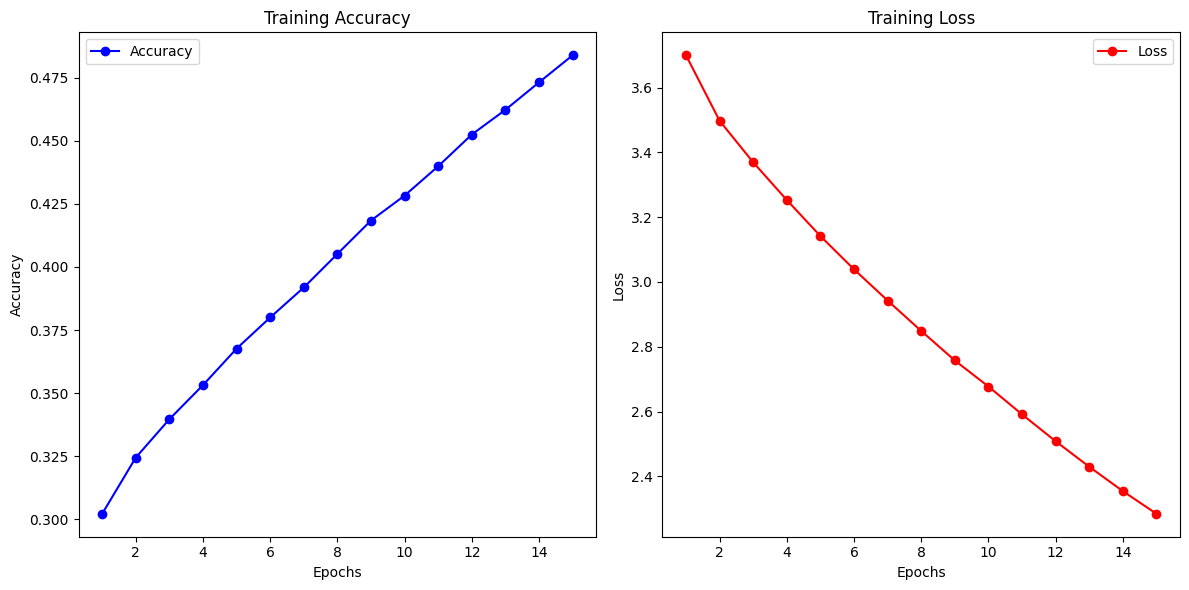

In [ ]:
import matplotlib.pyplot as plt
acc = hystory_with_lora.history['accuracy']
loss = hystory_with_lora.history['loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro-', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Before text generation, we need to merge the original weights with the product of two matrices.
The sizes of the LoRA tuning matrices do not match the sizes of the original weights in the self-attention layers of the GPT-2 model. The original weights have a form of (768, 12, 64) because they follow a multi-head attention mechanism with 12 attention heads, each having a weight matrix of size (768, 64).

To solve this problem, we need to make the reshaping and tiling operations adjust the lora_adjustment matrix to match the shape of the original weight without changing the total number of elements.

The approach is to expand the dimensions of lora_adjustment to (768, 12, 1) and then tile it to match the shape (768, 12, 64), ensuring that the LoRA adjustment is applied equally on the last dimension.

In [ ]:
for layer_idx in range(gpt2_model.backbone.num_layers):
    decoder_layer = gpt2_model.backbone.get_layer(f"transformer_layer_{layer_idx}")
    self_attention_layer = decoder_layer._self_attention_layer

    # update query dense layer weights
    query_dense_layer = self_attention_layer._query_dense
    if isinstance(query_dense_layer, LoraLayer):
        lora_adjustment = tf.matmul(query_dense_layer.lora_A, query_dense_layer.lora_B)  # original shape: (768, 12)
        lora_adjustment = tf.expand_dims(lora_adjustment, axis=-1)  # expand dims to (768, 12, 1)
        lora_adjustment = tf.tile(lora_adjustment, [1, 1, query_dense_layer.original_weight.shape[-1]])  # tile to match the shape (768, 12, 64)

        # merge original weight with the two matrices
        new_weights = query_dense_layer.original_weight + lora_adjustment * query_dense_layer.alpha
        query_dense_layer.base_dense_layer.set_weights([new_weights, query_dense_layer.original_bias])



### Inference

In [ ]:
prompt_text = "Yesterday I saw"
generated_text_ids = gpt2_model.generate([prompt_text], max_length=50)
generated_text = generated_text_ids[0]

print("Text generated:", generated_text)

Text generated: Yesterday I saw this film at the Cannes Film Festival. I was looking forward to seeing the film because I was excited to see the story of a young girl, Risa, who is searching for a love with the man who she has met online


1. The movie is very boring and very uninteresting. The actors are just mediocre and the plot is not even funny. I don't think anyone expected a good movie like this, it just plain sucks.

2. The movie is a good one. The characters are believable, the plot interesting. The acting is decent and it is a bit forgettable. The story is pretty forgettable, but it's not really bad either.

3. The movie is a great movie. It has some nice scenes but the acting is not the best. The movie is not realistic. The plot is not the most interesting.

4. Yesterday I saw this film at the Cannes Film Festival. I was looking forward to seeing the film because I was excited to see the story of a young girl, Risa, who is searching for a love with the man who she has met online.

After performing inference using GPT-2 with the integration of Low-Rank Adaptation, we can see positive results in text generation. Although LoRA adaptation involves modifying and training a relatively small number of parameters compared to the entire GPT-2 set, the quality of the generated text appears to be better than the original model (see below). This demonstrates the effectiveness of the LoRA approach in improving the capabilities of a pre-trained model like GPT-2, allowing targeted adaptability to specific tasks without compromising the quality of the output. We see the biggest advantage in terms of computational and resource efficiency.

### GPT2 without LoRA

In [ ]:
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=128,
)
gpt2_model_without_lora = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor,
)

In [ ]:
gpt2_model_without_lora.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)


In [ ]:
num_epochs = 15
history_without_lora = gpt2_model_without_lora.fit(train_ds, epochs=num_epochs)


Epoch 1/15
63/63 [==============================] - 140s 1s/step - loss: 3.9861 - accuracy: 0.2694
Epoch 2/15
63/63 [==============================] - 61s 969ms/step - loss: 3.1200 - accuracy: 0.3548
Epoch 3/15
63/63 [==============================] - 61s 969ms/step - loss: 2.5152 - accuracy: 0.4264
Epoch 4/15
63/63 [==============================] - 61s 968ms/step - loss: 2.0258 - accuracy: 0.4935
Epoch 5/15
63/63 [==============================] - 61s 969ms/step - loss: 1.5738 - accuracy: 0.5711
Epoch 6/15
63/63 [==============================] - 61s 968ms/step - loss: 1.1785 - accuracy: 0.6504
Epoch 7/15
63/63 [==============================] - 61s 967ms/step - loss: 0.8691 - accuracy: 0.7206
Epoch 8/15
63/63 [==============================] - 61s 968ms/step - loss: 0.6406 - accuracy: 0.7803
Epoch 9/15
63/63 [==============================] - 61s 968ms/step - loss: 0.4838 - accuracy: 0.8235
Epoch 10/15
63/63 [==============================] - 61s 967ms/step - loss: 0.3808 - accuracy

In [ ]:
model_save_path = '/content/drive/My Drive/NNDS modelli/gpt2_model_without_lora'
gpt2_model_without_lora.save(model_save_path)


In [ ]:
prompt_text = "The movie is"
generated_text_ids = gpt2_model_without_lora.generate([prompt_text], max_length=50)
generated_text = generated_text_ids[0]

print("Text generated:", generated_text)

Text generated: The movie is boring because of too many characters and scenarios being thrown together together into a film that is amateurish at the start and finish. The actors are amateurish and unbelievable for their part. Even Glenn Close (and she is normally very good


1. Yesterday I saw the premiere of Zero Day...and i have even liked it quite a bit, even though i did not like the film and wanted to give it a 10...So i did like the film and could understand the drama.

2. The movie is a collection of cliche's on how dumb Hollywood treats its audience. It is a collection of cliche's on just how dumb Hollywood treats the audience. How dumb can Hollywood continue to crank out one horrible update of a classic

3. Yesterday I saw The Human Tornado, and I was sunk down flat on my feet, with tears from laughter from the Simon Peepers. Yesterday I watched it again.

4. The movie is boring, the characters and scenarios are unrealistic, unbelievable, the action is hilarious. And the director made a great use of stock footage from the 1950's to early 2000's to make his characters believable.

5. The movie is great! I saw it a couple of months ago and I thought it might be a good idea to see it again. I don't know if it's been done before, but I must have missed it.



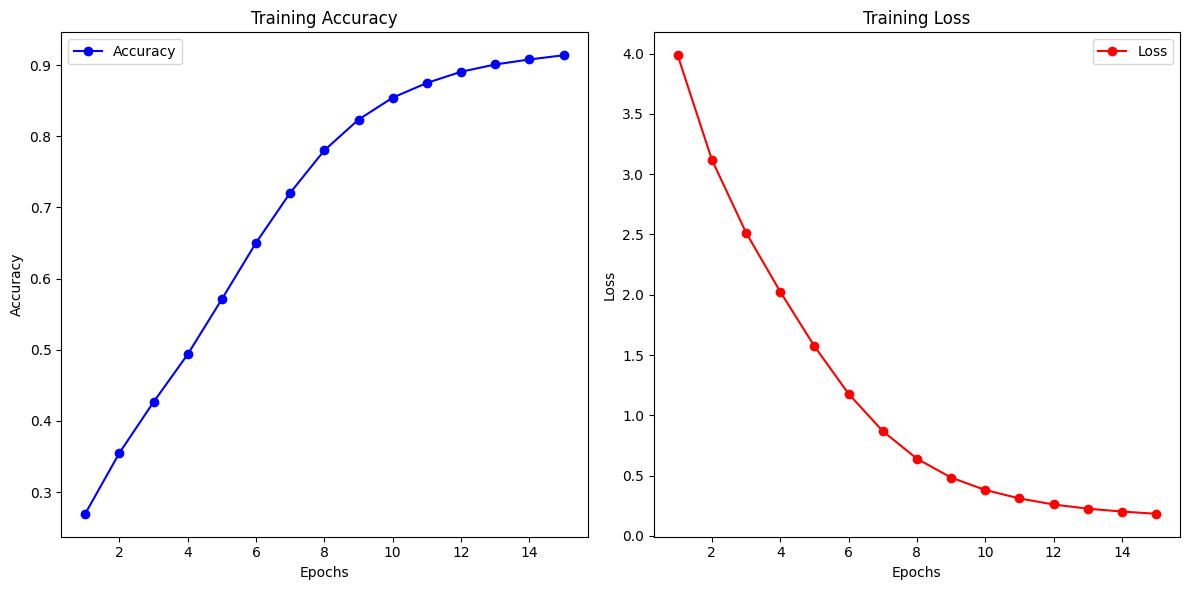

In [ ]:
import matplotlib.pyplot as plt
acc = history_without_lora.history['accuracy']
loss = history_without_lora.history['loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro-', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Hard-prompting

To see how hard prompting behaved in this case I use a fixed prompt (in this case, the string "Review: ") added directly to the input text before the inference. This text string acts as a sort of instruction to the model, telling it the context or type of response expected.

In [ ]:
# define a prompt
prompt = "Review: "


In [ ]:
# preprocess the dataset to include the soft prompt
def add_prompt(review, label):
    review_with_prompt = tf.strings.join([prompt, review])
    return review_with_prompt, label

In [ ]:
train_ds = (
    imdb_reviews_ds
    .map(add_prompt)  # add the prompt to each review
    .map(lambda review, _: review)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=128 + len(prompt)  # adjust for the length of the prompt
)
gpt2_model_prompting = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor,
)

In [ ]:
gpt2_model_prompting.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)


In [ ]:
num_epochs = 15
gpt2_model_prompting.fit(train_ds, epochs=num_epochs)

In [ ]:
prompt_text = "The ending wasn't what I expected"
generated_text_ids = gpt2_model_prompting.generate([prompt_text], max_length=50)
generated_text = generated_text_ids[0]

print("Text generated:", generated_text)

1. The ending wasn't what I expected, but it didn't take long before I started watching. It was interesting, and somewhat entertaining. <.br /><.br /> Jo Jones is great, as usual. But the story is pretty stale, as usual


As we expected, this technique is not ideal for a task of this type as it does not exploit the flexibility and adaptability of soft prompts, which can vary and optimize during training.

### Exercise 2: Interpreting the results (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercise 1, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1 and 2 for a total of *15 points*.

[LIME](https://arxiv.org/abs/1602.04938) (**Local Interpretable Model-agnostic Explanations**) is a very common explainability method, which trains a small interpretable model (e.g., a linear model) around a prediction $f(x)$ to interpret the prediction. For this exercise:

1. Read carefully the original LIME paper.
2. Re-implement the LIME algorithm and test it on 1 or 2 predictions given by your neural network (from Exercise 1).
3. This must be done fully in TensorFlow (same as the previous exercise).
4. LIME requires to select how to represent the inputs (e.g., patches of the original image). Explain your choice below.
5. Analyze the results you obtain.

In [ ]:
# TODO: Implement and test LIME.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

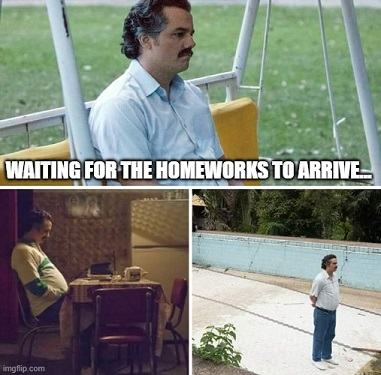